In [63]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model import *
from utils import *

import pandas as pd

In [64]:
# read MS data
df_nodes_orange1 = pd.read_csv("graphs_data/nodes_Orange_1.csv")
df_nodes_orange1

,idx,id,0,1,2
0,0,4,-5.036212,-4.036212,-5.036212
1,1,33,4.393324,4.320525,5.374856
2,2,40,4.783502,4.564263,4.901967
3,3,50,4.137408,4.552624,4.098589
4,4,61,3.338557,3.296510,3.156526
...,...,...,...,...,...
1774,1774,2277,5.526112,5.385147,5.351916
1775,1775,2301,4.147657,4.617270,4.561308
1776,1776,2304,4.909301,5.034440,4.997961
1777,1777,2305,4.770953,5.085971,5.154957


In [65]:
df_edges_orange1 = pd.read_csv("graphs_data/edges_Orange_1.csv")
df_edges_orange1

,source,target,weight,subgroup
0,0,1,0.675432,1
1,0,2,0.932253,1
2,0,3,-0.995776,1
3,0,4,-0.533443,1
4,0,5,-0.643461,1
...,...,...,...,...
1098764,1775,1777,-0.957947,1
1098765,1775,1778,-0.787670,1
1098766,1776,1777,-0.867200,1
1098767,1776,1778,-0.626310,1


In [66]:
data = "Mentos" # args.dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
    train_set = ["ACM", "DBLP"]
    input_dim = 17
    b = np.load('data/ACM-DBLP.npz')
    train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
    train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
    test_pairs = b['test_pairs'].astype(np.int32)
    
    NUM_HIDDEN_LAYERS = 12
    HIDDEN_DIM = 1024
    output_feature_size = 1024
    lr = 0.0001
    epoch = 100
elif (data == "Douban Online_Offline"):
    a1, f1, a2, f2, test_pairs = load_douban()
    f1 = f1.A
    f2 = f2.A
    train_set = ["Online", "Offline"]
    input_dim = 538
    test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
    test_pairs = test_pairs.numpy()
    train_features["Online"] = [torch.from_numpy(f1).float()]
    train_features["Offline"] = [torch.from_numpy(f2).float()]
    
    NUM_HIDDEN_LAYERS = 6
    HIDDEN_DIM = 512
    output_feature_size = 512
    lr = 0.0001
    epoch = 100
elif (data == "Mentos"):
    train_set = ["Red_1", "Red_2"] # change
    input_dim = 3
    
    df_nodes_orange1 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[0]))
    df_nodes_orange2 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[1]))
    
    train_features[train_set[0]] = [torch.from_numpy(df_nodes_orange1.iloc[:, 2:].values).float()]
    train_features[train_set[1]] = [torch.from_numpy(df_nodes_orange2.iloc[:, 2:].values).float()]
    
    NUM_HIDDEN_LAYERS = 12
    HIDDEN_DIM = 1024
    output_feature_size = 1024
    lr = 0.0001
    epoch = 100


In [67]:
train_features

{'Red_1': [tensor([[5.1211, 5.1138, 5.0902],
          [3.3674, 2.8250, 3.4561],
          [4.5325, 4.2880, 3.9586],
          ...,
          [4.6330, 4.4071, 4.4298],
          [4.7459, 4.6275, 4.7239],
          [3.8109, 2.8876, 3.8549]])],
 'Red_2': [tensor([[4.8982, 4.9177, 4.8484],
          [4.9550, 5.2334, 5.6829],
          [4.6404, 4.4733, 4.3203],
          ...,
          [4.5787, 4.6606, 4.5928],
          [5.1339, 4.9869, 5.1214],
          [5.2512, 5.0784, 5.2259]])]}

In [68]:
""" temp = torch.from_numpy(b["x1"]).float() # G1, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x1"]).float() # G1, features\nprint(temp.shape)\ntemp '

In [69]:
""" temp = torch.from_numpy(b["x2"]).float() # G2, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x2"]).float() # G2, features\nprint(temp.shape)\ntemp '

In [70]:
""" temp = b["test_pairs"]
print(temp.shape)
temp """

' temp = b["test_pairs"]\nprint(temp.shape)\ntemp '

In [71]:
try:
    test_pairs
except:
    pass

In [72]:
train_set

['Red_1', 'Red_2']

In [73]:
# for Mentos
encoder = "GIN"
use_input_augmentation = True
use_output_augmentation = False
print("Loading training datasets")
train_loader = {}
for dataset in train_set:
    df_edges_orange = pd.read_csv("graphs_data/edges_{}.csv".format(dataset))
    edges = df_edges_orange.iloc[:, [0, 1]].values
    
    n = train_features[dataset][0].shape[0]
    matrix = torch.zeros(n, n)

    for item in edges:
        matrix[item[0]][item[1]] = 1
        matrix[item[1]][item[0]] = 1

    train_loader[dataset] = [matrix]

train_loader

Loading training datasets


{'Red_1': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 0.,  ..., 1., 0., 1.],
          [0., 1., 0.,  ..., 1., 1., 0.]])],
 'Red_2': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 1., 0., 1.],
          [0., 0., 0.,  ..., 1., 1., 0.]])]}

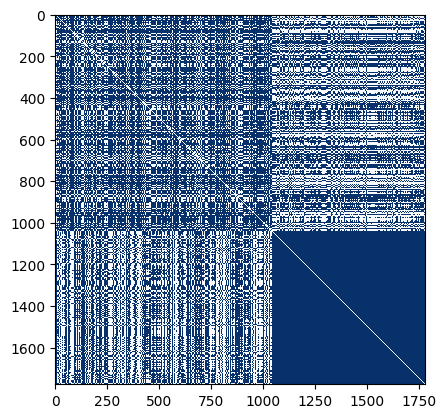

In [75]:
# test heatmap
import matplotlib.pyplot as plt 

data = np.random.random(( 12 , 12 )) 
plt.imshow(train_loader[train_set[0]][0].cpu().numpy(), cmap="Blues", interpolation="none")
plt.show() 

In [45]:
""" temp = train_loader["ACM"][0]
print(temp.shape)
temp """

' temp = train_loader["ACM"][0]\nprint(temp.shape)\ntemp '

In [46]:
""" temp = train_loader["DBLP"][0]
print(temp.shape)
temp """

' temp = train_loader["DBLP"][0]\nprint(temp.shape)\ntemp '

In [76]:
model = GAE(NUM_HIDDEN_LAYERS,
            input_dim,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=use_input_augmentation,
            use_output_augmentation=use_output_augmentation,
            encoder=encoder).to(device)
model

GAE(
  (base_gcn): GIN(
    (in_proj): Linear(in_features=3, out_features=1024, bias=True)
    (convs): ModuleList(
      (0-13): 14 x GINConv(
        (linear): Linear(in_features=1027, out_features=1024, bias=True)
      )
    )
    (out_proj): Linear(in_features=15360, out_features=1024, bias=True)
  )
)

In [48]:
print("Generating training features")


Generating training features


In [77]:
print("Fitting model")
# fit_GAE_real(data, len(train_set) * (1 + 1), model, epoch, train_loader, train_features, device, lr,test_pairs)
# fit_GAE_real(data, no_samples, GAE, epoch, train_loader, train_features, device, lr, test_pairs):

no_samples = len(train_set) * (1 + 1)
GAE = model
# ---

best_hitAtOne = 0
best_hitAtFive = 0
best_hitAtTen = 0
best_hitAtFifty = 0
optimizer = Adam(GAE.parameters(), lr=lr, weight_decay=5e-4)

for step in tqdm(range(epoch)):
    loss = 0
    
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z,z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()

    # ---
    keys = list(train_loader.keys())
    S1 = train_loader[keys[0]][0]
    S2 = train_loader[keys[1]][0]
    
    adj_S1 = coo_matrix(S1.numpy())
    adj_norm_1 = preprocess_graph(adj_S1)
    adj_norm_1 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_1[0].T),
                                            torch.FloatTensor(adj_norm_1[1]),
                                            torch.Size(adj_norm_1[2])).to(device)
    adj_S2 = coo_matrix(S2.numpy())
    adj_norm_2 = preprocess_graph(adj_S2)
    adj_norm_2 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_2[0].T),
                                            torch.FloatTensor(adj_norm_2[1]),
                                            torch.Size(adj_norm_2[2])).to(device)
    """ if (data == "ACM_DBLP"):
        S1_feat = train_features["ACM"][0]
        S2_feat = train_features["DBLP"][0]
    elif (data == "Douban Online_Offline"):
        S1_feat = train_features["Online"][0]
        S2_feat = train_features["Offline"][0] """
    
    S1_feat = train_features[list(train_features.keys())[0]][0]
    S2_feat = train_features[list(train_features.keys())[1]][0]
        

    # ---
    S1_emb = GAE(S1_feat.to(device), adj_norm_1).detach()
    S2_emb = GAE(S2_feat.to(device), adj_norm_2).detach()

    D = torch.cdist(S1_emb, S2_emb, 2) # Euclidean distance
    
    """ if (data == "ACM_DBLP"):
        test_idx = test_pairs[:, 0].astype(np.int32)
        labels = test_pairs[:, 1].astype(np.int32)
    elif (data == "Douban Online_Offline"):
        test_idx = test_pairs[0, :].astype(np.int32)
        labels = test_pairs[1, :].astype(np.int32)
    
    hitAtOne = 0
    hitAtFive = 0
    hitAtTen = 0
    hitAtFifty = 0
    hitAtHundred = 0
    
    # test
    
    for i in range(len(test_idx)): # here
        dist_list = D[test_idx[i]]
        # print(i, test_idx[i], dist_list)
        sorted_neighbors = torch.argsort(dist_list).cpu()
        label = labels[i]
        
        "" " if i == 0:
            print(label, sorted_neighbors[0].item(), sorted_neighbors)
            # 6829 6829 tensor([6829, 3102,  601,  ..., 7878, 9701, 2044]) "" "
        
        for j in range(100):
            if (sorted_neighbors[j].item() == label):
                if (j == 0):
                    hitAtOne += 1
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 4):
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 9):
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 49):
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 100):
                    hitAtHundred += 1
                    break
    
    cur_hitAtOne = hitAtOne / len(test_idx)
    cur_hitAtFive = hitAtFive / len(test_idx)
    cur_hitAtTen = hitAtTen / len(test_idx)
    cur_hitAtFifty = hitAtFifty / len(test_idx)

    if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
    if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
    if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
    if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty """

Fitting model


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


In [50]:
print("The best results achieved:")
print("Hit@1: ", end="")
print(best_hitAtOne)
print("Hit@5: ", end="")
print(best_hitAtFive)
print("Hit@10: ", end="")
print(best_hitAtTen)
print("Hit@50: ", end="")
print(best_hitAtFifty)

The best results achieved:
Hit@1: 0
Hit@5: 0
Hit@10: 0
Hit@50: 0


In [52]:
D.shape

torch.Size([1779, 1771])

In [53]:
D

tensor([[22.1963, 88.3446, 79.3512,  ..., 90.4766, 91.3752, 92.4457],
        [66.0542,  7.0926,  6.7543,  ...,  8.1918,  9.2653, 10.4326],
        [61.3906, 16.7103,  3.0085,  ..., 17.5355, 18.6188, 19.7179],
        ...,
        [63.0281, 16.0655,  2.4383,  ..., 16.6809, 17.7576, 18.8258],
        [66.6730,  8.7997,  5.2587,  ...,  9.3415, 10.4180, 11.5057],
        [60.6504, 11.0528,  6.3670,  ..., 12.8117, 13.8120, 14.9615]],
       device='cuda:0')

In [ ]:
def hungarian(D):
    print("0")
    P = torch.zeros_like(D)
    matrix = D.tolist()
    m = Munkres()
    print("1")
    indexes = m.compute(matrix)
    print("2")
    total = 0
    for r, c in tqdm(indexes):
        print(r)
        P[r][c] = 1
        total += matrix[r][c]
    return P.t()

# hungarian(D)

Truth

In [ ]:
print(test_pairs.shape)
print(test_pairs)

In [ ]:
if (data == "ACM_DBLP"):
    test_pairs_ = test_pairs
elif (data == "Douban Online_Offline"):
    test_pairs_ = test_pairs.T
    
truth = test_pairs_[test_pairs_[:, 1].argsort()]
print(truth.shape)
truth

Option 1

In [78]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_algorithm(cost_matrix):
    # Use the linear_sum_assignment method from scipy
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Total cost
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # The assignments are returned as (row, col) pairs
    assignments = list(zip(row_ind, col_ind))
    
    return total_cost, assignments

total_cost, assignments = hungarian_algorithm(D.cpu())

# print(f"Total Cost: {total_cost}")
# print(f"Assignments: {assignments}")

In [79]:
option1 = np.array(assignments)
option1 = option1[option1[:, 1].argsort()]
print(option1.shape)
option1

(1772, 2)


array([[ 656,    0],
       [ 397,    1],
       [1700,    2],
       ...,
       [ 621, 1769],
       [1022, 1770],
       [ 458, 1771]])

In [ ]:
def test_matching(truth, test):
    matching = []
    test = test.tolist()
    truth = truth.tolist()

    for item in test:
        if item in truth:
            matching.append(item)
    return matching

matching = test_matching(truth, option1)
print(len(matching))
print(len(matching) / len(truth))
matching

Analysis

In [80]:
train_set

['Red_1', 'Red_2']

In [81]:
# Analysis

df_nodes_orange1 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[0]))
df_nodes_orange1
map1 = dict(zip(df_nodes_orange1.iloc[:, 0].values, df_nodes_orange1.iloc[:, 1].values))
map1

df_nodes_orange2 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[1]))
df_nodes_orange2
map2 = dict(zip(df_nodes_orange2.iloc[:, 0].values, df_nodes_orange2.iloc[:, 1].values))
# map2


In [82]:
df_match = pd.DataFrame(option1)
df_match.columns = ["g1", "g2"]
df_match

,g1,g2
0,656,0
1,397,1
2,1700,2
3,674,3
4,538,4
...,...,...
1767,974,1767
1768,135,1768
1769,621,1769
1770,1022,1770


In [ ]:
df_nodes_orange1

In [83]:
df_match.replace({"g1": map1}, inplace=True) 
df_match.replace({"g2": map2}, inplace=True) 
df_match


,g1,g2
0,1451,13
1,900,14
2,1953,24
3,1495,28
4,1169,33
...,...,...
1767,2126,2153
1768,461,2171
1769,1334,2185
1770,2246,2225


In [84]:
df_match[df_match["g1"] == df_match["g2"]]

,g1,g2
496,1032,1032
980,1783,1783
1029,1883,1883


Option 2

In [ ]:
import pygmtools as pygm

X = pygm.hungarian(D.cpu().numpy())
print(X.shape)
X

In [ ]:
indices = []
row, col = X.shape
for i in range(row):
    for j in range(col):
        if X[i][j] == 1:
            indices.append([i, j])
option2 = np.array(indices)
option2 = option2[option2[:, 1].argsort()]
print(option2.shape)
option2

In [ ]:
matching = test_matching(truth, option2)
print(len(matching))
print(len(matching) / len(truth))
matching

In [ ]:
df_match = pd.DataFrame(option2)
df_match.columns = ["g1", "g2"]
df_match

df_match.replace({"g1": map1}, inplace=True) 
df_match.replace({"g2": map2}, inplace=True) 
df_match

df_match[df_match["g1"] == df_match["g2"]]

Option 3

In [ ]:
indices = []
for i in range(D.shape[0]):
    dist_list = D[i]
    sorted_neighbors = torch.argsort(dist_list).cpu()
    indices.append([i, sorted_neighbors[0]])

option3 = np.array(indices)
option3 = option3[option3[:, 1].argsort()]
print(option3.shape)
option3

In [ ]:
matching = test_matching(truth, option3)
print(len(matching))
print(len(matching) / len(truth))
matching

In [ ]:
df_match = pd.DataFrame(option2)
df_match.columns = ["g1", "g2"]
df_match

df_match.replace({"g1": map1}, inplace=True) 
df_match.replace({"g2": map2}, inplace=True) 
df_match

df_match[df_match["g1"] == df_match["g2"]]

---

In [ ]:
a = torch.tensor([[0.0,  0.0], [0.0, 1.0], [0.0,  2.0]])
print(a)
b = torch.tensor([[0.0, 1.0 ], [1.0,  1.0]])
print(b)
torch.cdist(a, b, p=2)

In [ ]:
a = torch.tensor([[4.01, 3.0, 2.0, 0.1, 4.0]])
print(a)
torch.argsort(a, dim=1)

In [ ]:
a = np.array([[9, 2, 3],
              [4, 5, 6],
              [7, 0, 5]])

a[a[:, 2].argsort()]
